In [ ]:
import delfi.distribution as dd

import matplotlib as mpl
import numpy as np
import pandas as pd
import time

from delfi.generator import Default
from delfi.utils.viz import plot_pdf
from lfimodels.channelomics.Channel import Channel
from lfimodels.channelomics.ChannelStats import ChannelStats
from matplotlib import pyplot as plt
%matplotlib inline

m = Channel()
gt = np.array([9, 25, 0.02, 0.002])
p = dd.Uniform(lower=0.5*gt, upper=1.5*gt)
s = ChannelStats()
g = Default(model=m, prior=p, summary=s)

out = g.gen(1)

In [ ]:
from delfi.inference import Basic

inf_basic = Basic(generator=g, n_components=2, n_hiddens=[25, 25])
log, train_data = inf_basic.run(n_train=2500)

## 13.5h runtime, 2500 simulations

In [4]:
import delfi.utils.io as io
import pickle

io.save(inf_basic, 'run_1.pkl')
pickle.dump(log, open('run_1_log.pkl', 'wb'))

In [11]:
xo = m.gen(gt.reshape(1,-1))
xo_stats = s.calc(xo[0])
posterior = inf_basic.predict(xo_stats)

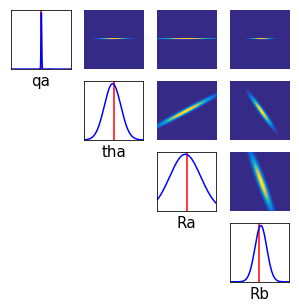

In [42]:
plot_pdf(posterior, 
         gt=gt, 
         ticks=False,
         labels_params=['qa','tha','Ra','Rb'],
         lims=np.asarray([[4.5, 13.5],
                          [12.5, 37.5],
                          [0.01, 0.03],
                          [0.001,0.003]]));